### 0. Import + Define Support Function

In [1]:
import yfinance as yf
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_order
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Simple Moving Average
def sma(s, window): 
    return s.rolling(window, min_periods=window).mean()

# Exponential Moving Average
def ema(s, span):
    return s.ewm(span=span, adjust=False).mean()

# Relative Strength Index
def rsi(s, window=14):
    delta = s.diff()
    gain = (delta.clip(lower=0)).rolling(window, min_periods=window).mean()
    loss = (-delta.clip(upper=0)).rolling(window, min_periods=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence
def macd(s, fast=12, slow=26, signal=9):
    ema_fast = ema(s, fast)
    ema_slow = ema(s, slow)
    line = ema_fast - ema_slow
    signal_line = ema(line, signal)
    hist = line - signal_line
    return line, signal_line, hist

# Bollinger Bands
def bollinger(s, window=20, num_std=2):
    ma = s.rolling(window, min_periods=window).mean()
    std = s.rolling(window, min_periods=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return ma, upper, lower

# Evaluation
def evaluate(y_true, y_pred, name="model"):
    # y_true = np.array(y_true)
    # y_pred = np.array(y_pred)

    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    # Directional Accuracy
    da   = (np.sign(y_true.values) == np.sign(y_pred)).mean()
    return {"model": name, "RMSE": rmse, "MAE": mae, "DirAcc": da}

### 1. Data download + 2. Make DataFrame

In [2]:
# Date Setup
start, end = "2020-01-01", "2024-12-31"

# Yahoo Finance Data download
yahoo_symbols = {
    "S&P500": "^GSPC",          # S&P 500 Index
    "NASDAQ": "^IXIC",          # NASDAQ Composite
    "US10Y": "^TNX",            # 10-year Treasury Yield
    "DollarIndex": "DX-Y.NYB",  # Dollar Index
    "Oil": "CL=F",              # Crude Oil futures
    "Gold": "GC=F",             # Gold futures
    "VIX": "^VIX",              # CBOE Volatility Index
    "Silver": "SI=F",          # Silver futures
    "Copper": "HG=F",          # Copper futures
    "NatGas": "NG=F",        # Natural Gas futures
}

market_data = {}
for name, ticker in yahoo_symbols.items():
    data = yf.download(ticker, start=start, end=end)
    if 'Adj Close' in data.columns:
        market_data[name] = data['Adj Close']
    elif 'Close' in data.columns:
        market_data[name] = data['Close']

# Data Frame yahoo
df_yahoo = pd.concat(market_data, axis=1)
df_yahoo.index.name = "date"
df_yahoo = df_yahoo.sort_index()

# FRED Data download
fred_symbols = {
    "FedFundsRate": "FEDFUNDS",
    "CPI": "CPIAUCSL",
    "Unemployment": "UNRATE",
    "UMichSentiment": "UMCSENT",   # Univ. of Michigan Consumer Sentiment
    "FSI_StLouis": "STLFSI4",      # St. Louis Fed Financial Stress Index(
}

fred_data = {}
for name, series in fred_symbols.items():
    fred_data[name] = pdr.DataReader(series, data_source="fred", start=start, end=end)

# Data Frame FRED
df_fred = pd.concat(fred_data, axis=1)
df_fred.index.name = "date"
df_fred = df_fred.sort_index()

# FRED Monthly data --> Daily data (by forward fill)
base_index = df_yahoo.index
df_fred_daily = df_fred.reindex(base_index)

# Release lag days for economic indicators
release_lag_days = {
    "CPI": 14,
    "Unemployment": 14,
    "FedFundsRate": 7,
    "UMichSentiment": 7,
    "FSI_StLouis": 7,
}


for col, lag in release_lag_days.items():
    df_fred_daily[col] = df_fred_daily[col].shift(lag)
df_fred_daily = df_fred_daily.ffill()

# Combine Yahoo and FRED data + Add Technical Indicators
df = df_yahoo.join(df_fred_daily, how="inner")

price = df["S&P500"]

# SMA
df["spx_sma5"]  = sma(price, 5)
df["spx_sma20"] = sma(price, 20)
df["spx_sma60"] = sma(price, 60)

# EMA
df["spx_ema12"] = ema(price, 12)
df["spx_ema26"] = ema(price, 26)

# RSI(14)
df["spx_rsi14"] = rsi(price, 14)

# MACD(12,26,9)
macd_line, macd_signal, macd_hist = macd(price, 12, 26, 9)
df["spx_macd"]        = macd_line
df["spx_macd_signal"] = macd_signal
df["spx_macd_hist"]   = macd_hist

# Bollinger(20, 2σ)
bb_ma, bb_up, bb_lo = bollinger(price, 20, 2)
df["spx_bb_ma20"]   = bb_ma
df["spx_bb_up20"]   = bb_up
df["spx_bb_lo20"]   = bb_lo

df = df.dropna(how="any")
df.columns = df.columns.get_level_values(0)

/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/388274644.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/388274644.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/388274644.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/388274644.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True


### 3. Data Check

In [3]:
# Data statistics check
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S&P500,1122.0,4316.506177,722.876912,2797.800049,3879.172485,4220.284912,4567.344971,6090.270020
NASDAQ,1122.0,13635.389990,2475.856876,8494.750000,11670.359863,13474.109863,15120.132324,20173.890625
US10Y,1122.0,2.709663,1.386149,0.515000,1.439250,2.980500,3.976000,4.988000
DollarIndex,1122.0,99.908102,6.033418,89.440002,93.629997,101.669998,104.557499,114.110001
Oil,1122.0,72.878645,19.212265,12.340000,66.112497,75.310001,82.820000,123.699997
Gold,1122.0,1958.453117,265.346459,1623.300049,1788.699951,1872.599976,1978.775024,2788.500000
VIX,1122.0,21.019332,5.818224,11.860000,16.464999,20.030001,24.735000,41.980000
Silver,1122.0,24.365399,3.595851,14.722000,22.460000,24.086500,26.350750,34.831001
Copper,1122.0,3.914390,0.563847,2.317500,3.617875,4.041750,4.328875,5.119000
NatGas,1122.0,3.658183,1.893331,1.482000,2.396500,2.861000,4.567750,9.680000


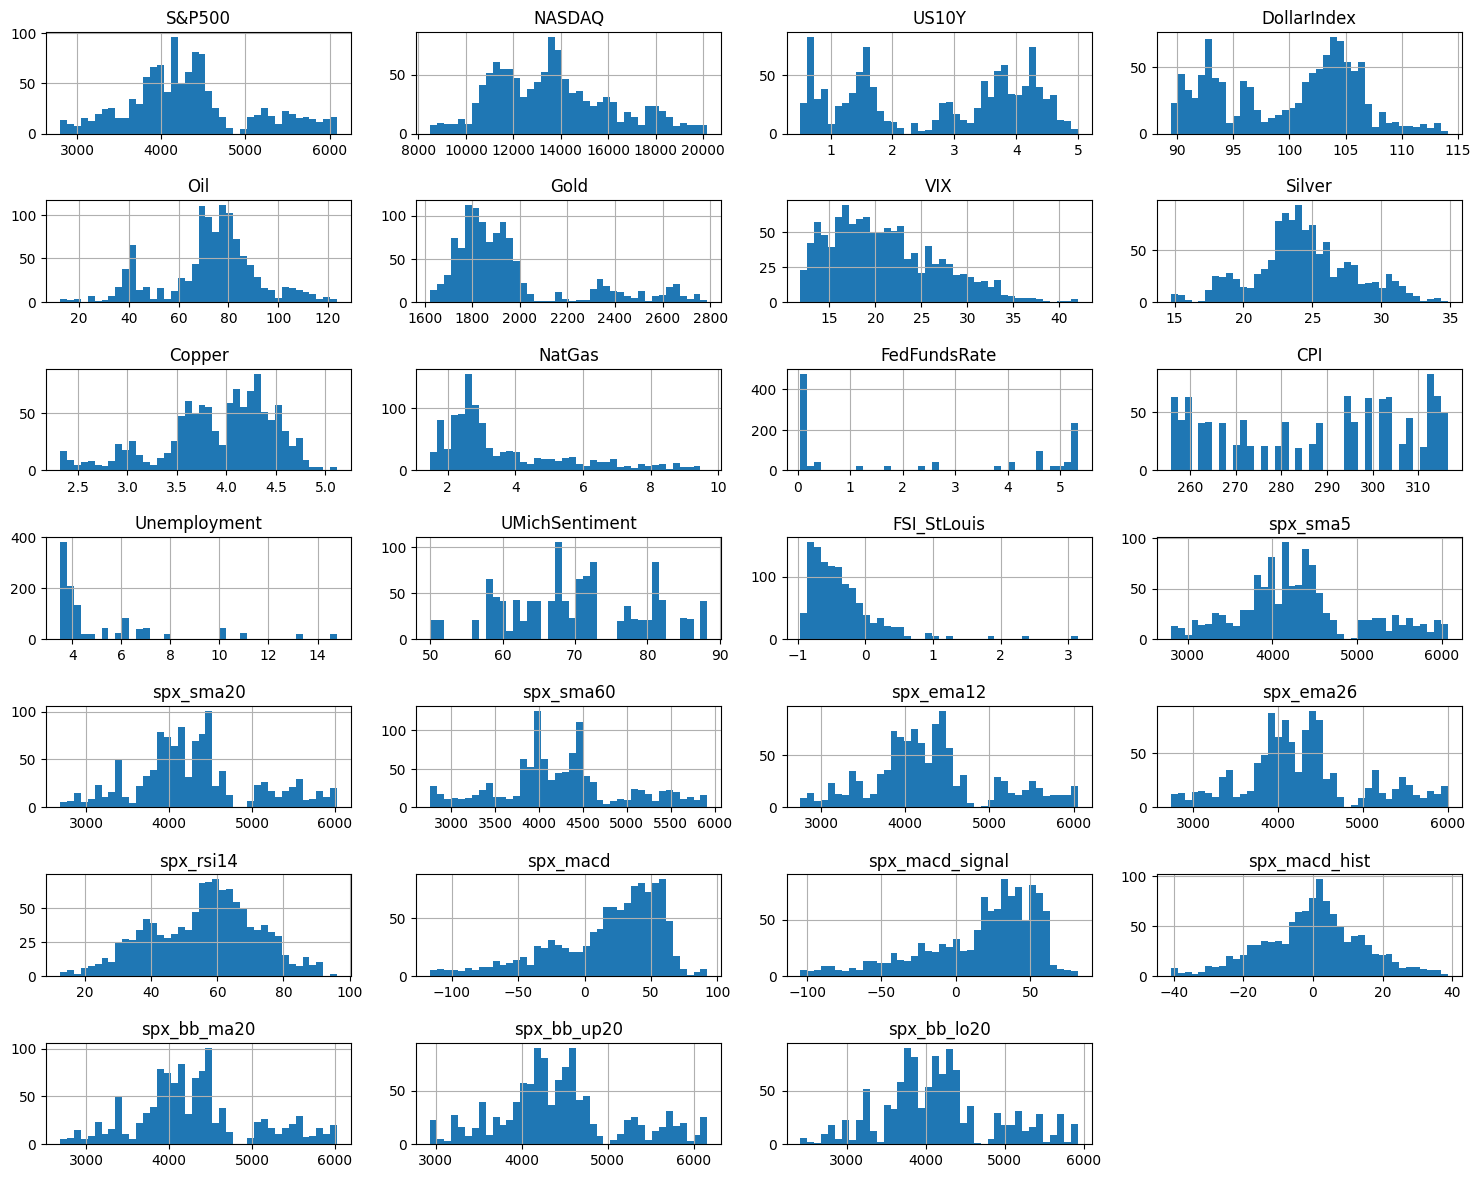

In [4]:
# Data dsitribution check
df.hist(bins=40, figsize=(15,12), layout=(7,4))
plt.tight_layout(pad=1.5)
plt.show() 

In [5]:
# Data correlation check
corr_spx = df.corr()["S&P500"].sort_values(ascending=False)
corr_spx

S&P500             1.000000
spx_sma5           0.997743
spx_ema12          0.995854
spx_ema26          0.991305
spx_bb_ma20        0.990345
spx_sma20          0.990345
spx_bb_lo20        0.988465
spx_bb_up20        0.985089
spx_sma60          0.975867
NASDAQ             0.955776
Gold               0.815997
CPI                0.732528
Silver             0.704066
Copper             0.683092
US10Y              0.615898
FedFundsRate       0.580627
Oil                0.402303
DollarIndex        0.317517
spx_macd_signal    0.182973
spx_macd           0.170861
spx_rsi14          0.112325
spx_macd_hist      0.004223
UMichSentiment    -0.037748
NatGas            -0.104542
FSI_StLouis       -0.578370
Unemployment      -0.582733
VIX               -0.663400
Name: S&P500, dtype: float64

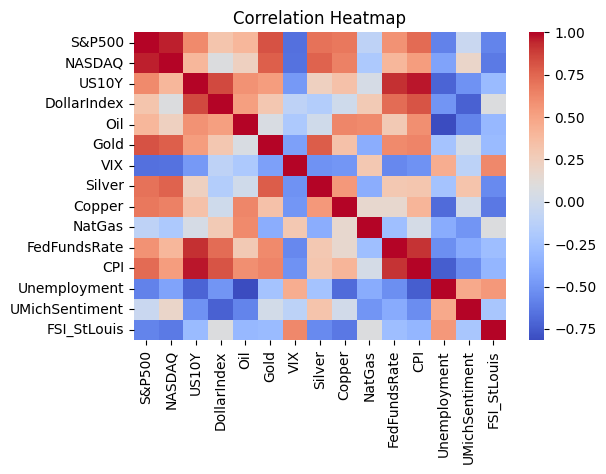

In [6]:
# Data correlation visulalization - excluded tech indicators
non_tech_cols = [col for col in df.columns if not col.startswith("spx_")]
df_nontech = df[non_tech_cols]
corr_nontech = df_nontech.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_nontech, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

### 4. Data Preprocessing

In [7]:
# Prepare data for modeling - Target data is tomorrow's S&P500 return
df_model = df.copy()
df_model["spx_ret"] = df_model["S&P500"].pct_change()
df_model["target"] = df_model["spx_ret"].shift(-1)
df_model = df_model.dropna(how="any")

In [8]:
# X variable and y variable preparation
X = df_model.drop(columns=["S&P500", "target", "spx_ret"])
y = df_model["target"]

# Train & Test Split
split_idx = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Scaling
scaler =StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5.1 Model - ARIMA

In [9]:
results_ARIMA = []

for p in [0,1,2]:
    for q in [0,1,2]:
        try:
            model = ARIMA(y_train, order=(p,0,q)).fit()
            preds = model.forecast(steps=len(y_test))
            score = mean_squared_error(y_test, preds) ** 0.5

            metrics = evaluate(y_test, preds, name="ARIMA")
            results_ARIMA.append(metrics)

        except Exception as e:
            continue

results_ARIMA_df = pd.DataFrame(results_ARIMA)
results_ARIMA_df

/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,model,RMSE,MAE,DirAcc
0,ARIMA,0.010187,0.006321,0.580357
1,ARIMA,0.010187,0.006320,0.580357
2,ARIMA,0.010187,0.006321,0.580357
3,ARIMA,0.010186,0.006320,0.580357
4,ARIMA,0.010197,0.006328,0.580357
5,ARIMA,0.010187,0.006321,0.580357
6,ARIMA,0.010188,0.006321,0.580357
7,ARIMA,0.010187,0.006321,0.580357
8,ARIMA,0.010194,0.006325,0.580357


In [10]:
# ARIMA Best Model Result
best_model_ARIMA = results_ARIMA_df.sort_values(
    by=["RMSE", "MAE", "DirAcc"], 
    ascending=[True, True, False]
).iloc[0]
best_model_ARIMA = best_model_ARIMA.to_dict()
best_model_ARIMA

{'model': 'ARIMA',
 'RMSE': 0.010186375063405511,
 'MAE': 0.006320151674736147,
 'DirAcc': 0.5803571428571429}

### 5.2 Model - VECM (Vector Error Correction Model)

In [11]:
# Column selection for VECM (Exclude technical indicators)
non_tech_cols = [col for col in df_model.columns if not col.startswith("spx_") and col != "target"]
vecm_data = df_model[non_tech_cols].dropna()

# Train/Test 
split_idx = int(len(vecm_data) * 0.8)
vecm_train, vecm_test = vecm_data.iloc[:split_idx], vecm_data.iloc[split_idx:]

# Lag order
lag_order = select_order(vecm_train, maxlags=5, deterministic="ci").aic

# co integration rank
rank_res = select_coint_rank(vecm_train, det_order=0, k_ar_diff=lag_order)
r = rank_res.rank

# VECM Model Fitting
vecm = VECM(vecm_train, k_ar_diff=lag_order, coint_rank=r, deterministic="ci").fit()

# lvl prediction    
vecm_forecast_lvl = vecm.predict(steps=len(vecm_test))

# S&P500 prediction extraction
target_name = "S&P500"
col_idx = vecm_train.columns.get_loc(target_name)
spx_pred_lvl = pd.Series(vecm_forecast_lvl[:, col_idx], index=vecm_test.index)

# convert level to return
spx_pred_ret = spx_pred_lvl.pct_change().dropna()

# Align y_test with spx_pred_ret
y_eval = y_test.loc[spx_pred_ret.index]

vecm_pred_ret = spx_pred_ret  # rename for later use
vecm_pred_ret.name = "VECM"

# Evaluation
metrics_vecm = evaluate(y_eval, spx_pred_ret, name="VECM")
metrics_vecm

/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. f

{'model': 'VECM',
 'RMSE': 0.010195739727907056,
 'MAE': 0.006332720585938417,
 'DirAcc': np.float64(0.547085201793722)}

### 5.3 Model - Random Forest

In [12]:
# Parameter grid for Randomized Search
param_grid = {
    'n_estimators': [200, 300, 500, 700, 1000],
    'max_depth': [5, 8, 10, 15, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
}

#  model initialization
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,             
    cv= TimeSeriesSplit(n_splits=5),                  
    random_state=42,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

rf_random_search.fit(X_train_scaled, y_train)

best_params = rf_random_search.best_params_
rf_best = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

# model training
rf_best.fit(X_train_scaled, y_train)

# prediction
rf_pred = rf_best.predict(X_test_scaled)

# evluation
metrics_rf = evaluate(y_test, rf_pred, name="RandomForest")
metrics_rf

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=700; total time=   1.1s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=3

{'model': 'RandomForest',
 'RMSE': 0.011865060778418547,
 'MAE': 0.00863084009555604,
 'DirAcc': np.float64(0.4330357142857143)}

### 5.4 Model - XGBoost

In [13]:
# Define model (default params first)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
)

# Fit
xgb_model.fit(X_train_scaled, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate
metrics_xgb = evaluate(y_test, xgb_pred, name="XGBoost_Baseline")
metrics_xgb


{'model': 'XGBoost_Baseline',
 'RMSE': 0.019142434535569044,
 'MAE': 0.016426109169520458,
 'DirAcc': np.float64(0.4330357142857143)}

In [14]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 0.5, 1.0, 2.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
}

tscv = TimeSeriesSplit(n_splits=5)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=40,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1,
)

xgb_random_search.fit(X_train_scaled, y_train)
best_params_xgb = xgb_random_search.best_params_
best_params_xgb


Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'subsample': 0.6,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'n_estimators': 800,
 'max_depth': 5,
 'learning_rate': 0.05,
 'colsample_bytree': 0.6}

In [15]:
# Train best model with tuned parameters
xgb_best = xgb.XGBRegressor(
    **best_params_xgb,
    objective='reg:squarederror',
    random_state=42
)
xgb_best.fit(X_train_scaled, y_train)
xgb_pred = xgb_best.predict(X_test_scaled)
metrics_xgb = evaluate(y_test, xgb_pred, name="XGBoost")
metrics_xgb

{'model': 'XGBoost',
 'RMSE': 0.01022021017752049,
 'MAE': 0.006349364166226097,
 'DirAcc': np.float64(0.5669642857142857)}

### 5.5 Model - LSTM (Deep Learning)

In [16]:
# X,y rescaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X.values)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

# Train/Test split
X_train_lstm = X_scaled[:split_idx]
X_test_lstm  = X_scaled[split_idx:]
y_train_lstm = y_scaled[:split_idx]
y_test_lstm  = y_scaled[split_idx:]

# windowing
window = 30

def create_lstm_dataset(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_train_lstm, y_train_lstm = create_lstm_dataset(X_train_lstm, y_train_lstm, window)
X_test_lstm, y_test_lstm   = create_lstm_dataset(X_test_lstm, y_test_lstm, window)

# LSTM Model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
])

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

# Training with EarlyStopping
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_split=0.2,
    epochs=60,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Prediction
lstm_pred_scaled = model_lstm.predict(X_test_lstm).flatten()
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler_y.inverse_transform(y_test_lstm.reshape(-1,1)).flatten()

# Evaluation 
metrics_lstm = evaluate(pd.Series(y_true), lstm_pred, name="LSTM")
metrics_lstm


Epoch 1/60


/Users/lee/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0127 - val_loss: 0.0030
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0073 - val_loss: 0.0030
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0029
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0032
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 8/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 9/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 10/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 11/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 12/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - val_loss: 0

{'model': 'LSTM',
 'RMSE': 0.008174939795619028,
 'MAE': 0.00597460800095451,
 'DirAcc': np.float64(0.5721649484536082)}

### 5.6 Collect Model Metrics into One DataFrame

In [17]:
# Collect metrics dictionaries
metrics_list = [
    best_model_ARIMA,    # ARIMA best metrics
    metrics_vecm,        # VECM
    metrics_rf,          # Random Forest
    metrics_xgb,         # XGBoost
    metrics_lstm         # LSTM
]

df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index("model")
display(df_metrics)

,RMSE,MAE,DirAcc
model,,,
ARIMA,0.010186,0.006320,0.580357
VECM,0.010196,0.006333,0.547085
RandomForest,0.011865,0.008631,0.433036
XGBoost,0.010220,0.006349,0.566964
LSTM,0.008175,0.005975,0.572165


/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/75423962.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics["RMSE"], ax=axes[0], palette="Blues_r")
/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/75423962.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y=df_metrics["MAE"], ax=axes[1], palette="Greens_r")
/var/folders/x1/blfgy5351ks1qxgg9q0726v00000gn/T/ipykernel_21952/75423962.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_metrics.index, y

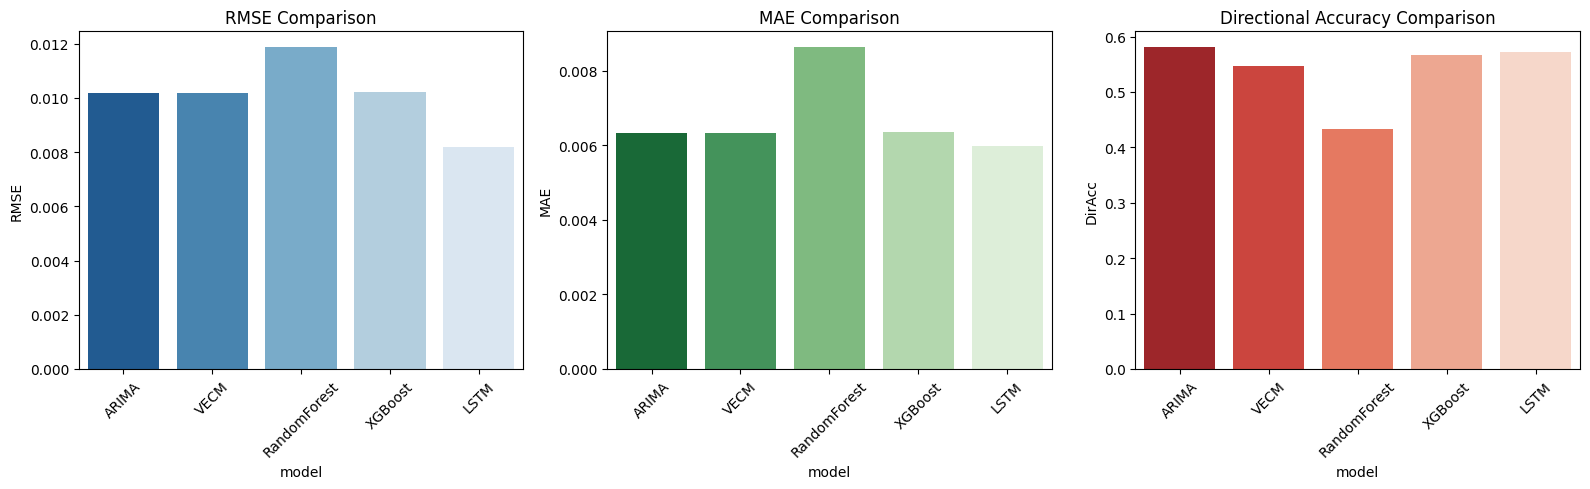

In [18]:
# Create 3 subplots (RMSE, MAE, DirAcc)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE Plot
sns.barplot(x=df_metrics.index, y=df_metrics["RMSE"], ax=axes[0], palette="Blues_r")
axes[0].set_title("RMSE Comparison")
axes[0].tick_params(axis='x', rotation=45)

# MAE Plot
sns.barplot(x=df_metrics.index, y=df_metrics["MAE"], ax=axes[1], palette="Greens_r")
axes[1].set_title("MAE Comparison")
axes[1].tick_params(axis='x', rotation=45)

# Directional Accuracy Plot
sns.barplot(x=df_metrics.index, y=df_metrics["DirAcc"], ax=axes[2], palette="Reds_r")
axes[2].set_title("Directional Accuracy Comparison")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 6. Visualization: Actual vs Predicted S&P500 Return over Time


/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/lee/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


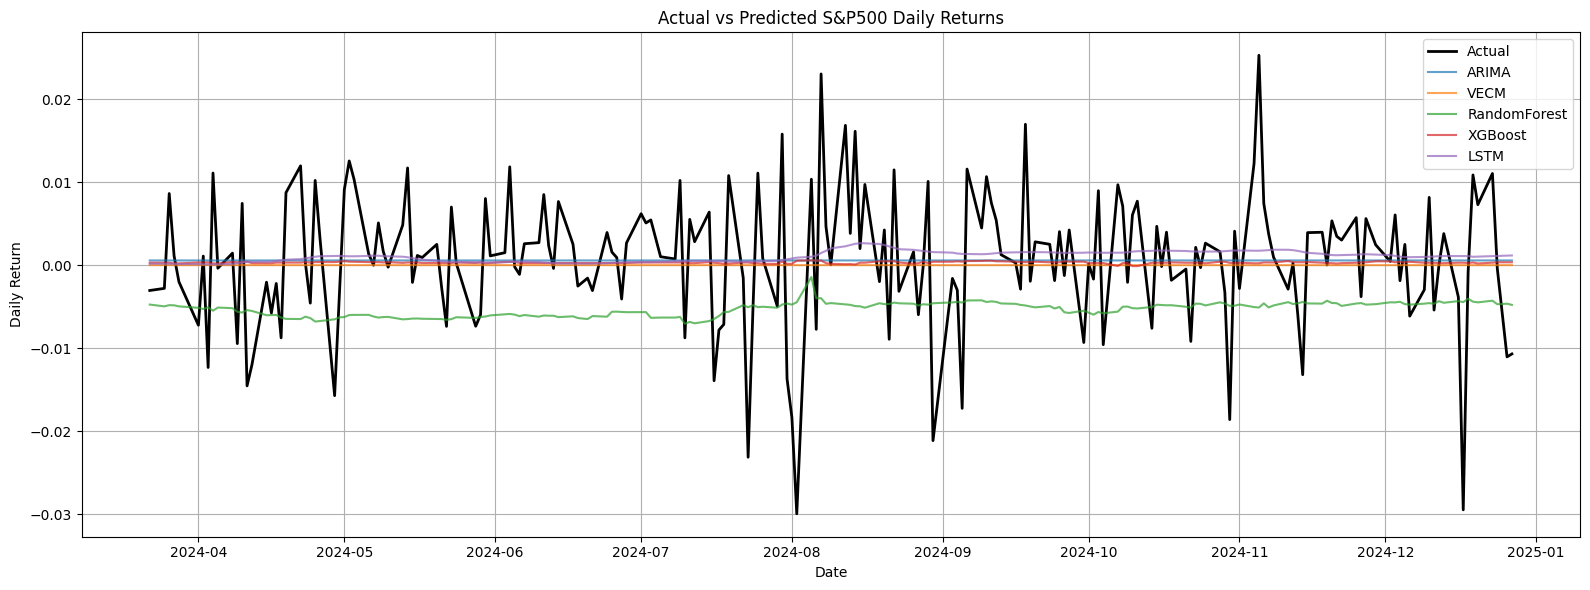

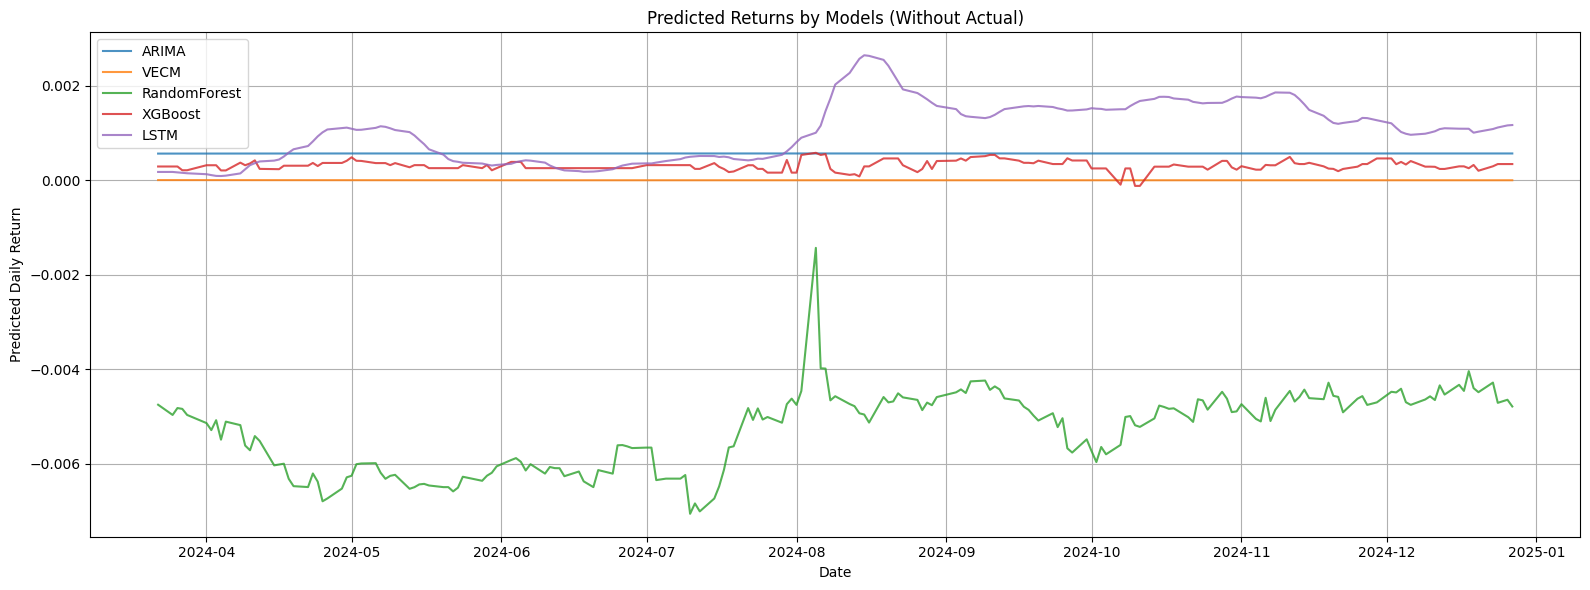

In [19]:
# Create Series for each model's prediction (make sure these variables exist)
# ARIMA Predictions
arima_pred = model.forecast(steps=len(y_test))
arima_pred.index = y_test.index
arima_pred.name = "ARIMA"

# VECM Predictions (defined earlier as vecm_pred_ret)
vecm_pred_ret.name = "VECM"

# Random Forest Predictions
rf_pred_series = pd.Series(rf_pred, index=y_test.index, name="RandomForest")

# XGBoost Predictions
xgb_pred_series = pd.Series(xgb_pred, index=y_test.index, name="XGBoost")

# LSTM Predictions (note: dropped first 'window' rows earlier, so align index)
lstm_pred_series = pd.Series(lstm_pred, index=y_test.index[-len(lstm_pred):], name="LSTM")
y_true_aligned = pd.Series(y_test.values[-len(lstm_pred):], index=lstm_pred_series.index, name="Actual")

# Combine into one DataFrame
df_preds = pd.concat([
    y_test.rename("Actual"),
    arima_pred,
    vecm_pred_ret,
    rf_pred_series,
    xgb_pred_series,
    lstm_pred_series
], axis=1).dropna()

# Plot
plt.figure(figsize=(16, 6))
plt.plot(df_preds.index, df_preds["Actual"], label="Actual", linewidth=2, color="black")

for col in df_preds.columns[1:]:
    plt.plot(df_preds.index, df_preds[col], label=col, alpha=0.7)

plt.title("Actual vs Predicted S&P500 Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot only model predictions (without Actual)
plt.figure(figsize=(16, 6))

for col in df_preds.columns[1:]:  # skip the Actual column
    plt.plot(df_preds.index, df_preds[col], label=col, alpha=0.8)

plt.title("Predicted Returns by Models (Without Actual)")
plt.xlabel("Date")
plt.ylabel("Predicted Daily Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()